# NeuralProphet Nuovi Positivi, Terapia Intensiva, Deceduti

In questo notebook sono stati utlizzati gli stessi dati del notebook https://colab.research.google.com/github/marco-mazzoli/progetto-tesi/blob/master/covid_multi_output.ipynb, ossia quelli regionali dell'Emilia-Romagna.
Sono in particolare stati usati i dati di ricoverati in terapia intensiva, deceduti e nuovi positivi fino al 6 Dicembre 2021.

Il modello NeuralProphet è stato utilizzato in modalità univariate ed autoregressiva con lag di 28 giorni per fare forecasting di 1, 2, 7 e 14 giorni.

L'ultimo 20% dei dati è stato escluso dalla fase di ricerca degli iper-parametri. Una volta stabiliti è stato usato l'intero dataset per fare previsione mantendo il primo 80% di train e il restante di test.

Gli iper-parametri su cui è stata fatta la ricerca sono learning-rate e numero di layer hidden della rete neurale.

Prima della fase di train i dati vengono scalati per poi essere riportati alla scala originale una volta effettuata la previsione.

Questo modello crea automaticamente i lag temporali.

In [23]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git

  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-b6o4denh
  Running command git clone -q https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-b6o4denh
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [24]:
import os

if 'google.colab' in str(get_ipython()):
    files = ['util.py',
             'windows.py',
             'models']

    for file in files:
        os.system('rm ./' + file)
        os.system(
            'wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/' + file)

import pandas as pd
from numpy.random import seed
from neuralprophet import NeuralProphet
import numpy as np

from util import select_relevant_rows, select_attributes, save_config, load_config



In [25]:
use_existing_config = True
column_to_predict = 'terapia_intensiva'
columns = ['nuovi_positivi', 'terapia_intensiva', 'deceduti']
split_percent = 0.80
region_focus = 'Emilia-Romagna'
attribute_focus = 'denominazione_regione'
n_futures = [1, 2, 7, 14]


In [26]:
local_region_path = r'../COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv'
remote_region_path = r'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'

regions_frame = pd.read_csv(remote_region_path)

region_focus_data = select_relevant_rows(
    regions_frame,
    attribute_focus,
    region_focus
)

df = select_attributes(region_focus_data, [
    'data',
    'ricoverati_con_sintomi',
    'terapia_intensiva',
    'totale_ospedalizzati',
    'variazione_totale_positivi',
    'nuovi_positivi',
    'deceduti',
    'tamponi',
    'ingressi_terapia_intensiva'
])

df = pd.DataFrame(df)
df['data'] = pd.to_datetime(
    df['data'])
df['data'] = df['data'].dt.strftime(
    r'%Y-%m-%d')
df['data'] = pd.to_datetime(df['data'])
# df = df[df['data'] < pd.to_datetime('2022-01-31')]
df = df.fillna(0)

df.rename(columns={'data': 'date'}, inplace=True)
df.set_index('date', inplace=True)

# revert cumulative data
df['deceduti'] = df['deceduti'].diff(
)
df['tamponi'] = df['tamponi'].diff(
)

df = df.astype('float')

# numpy seed
seed(1)

In [27]:
def define_np_configs():
    learning_rate = [0.001, 0.01, 0.05, 0.1]
    n_hidden = [0, 1, 2]

    configs = []
    keys = ['learning_rate', 'n_hidden']

    for i in learning_rate:
        for j in n_hidden:   
            config = dict(
                zip(keys, (i, j)))
            configs.append(config)

    return configs

In [28]:
def compute_mape(forecast, n_future):
    frcst = forecast.copy()
    frcst['y'][frcst['y'] == 0] = 0.1
    for i in range(n_future):
        frcst['perc'+str(i+1)] = np.abs(frcst['residual'+str(i+1)] / frcst['y'])

    perc = np.mean(frcst[['perc'+str(i+1) for i in range(n_future)]])
    return perc.mean()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.259% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.003 256.530 273.213
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.7

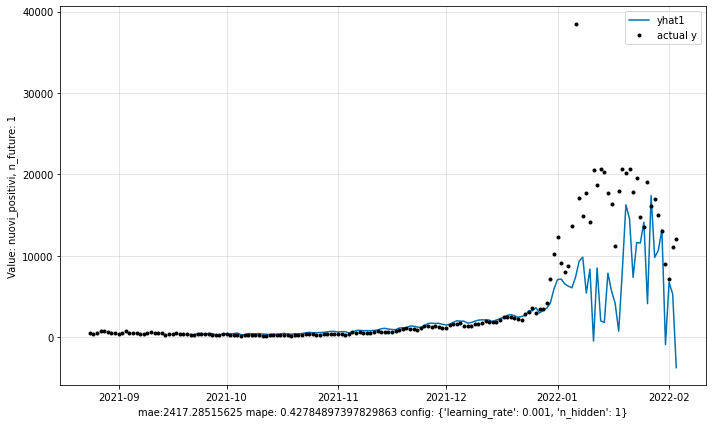

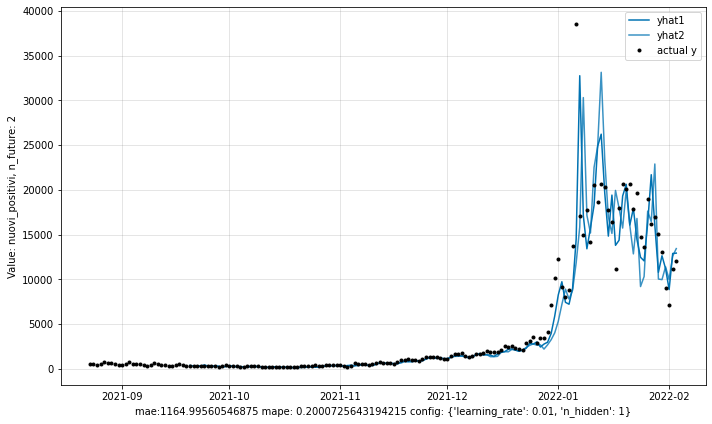

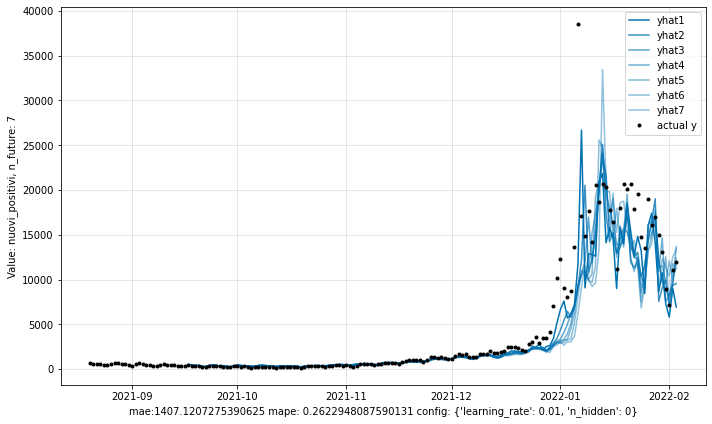

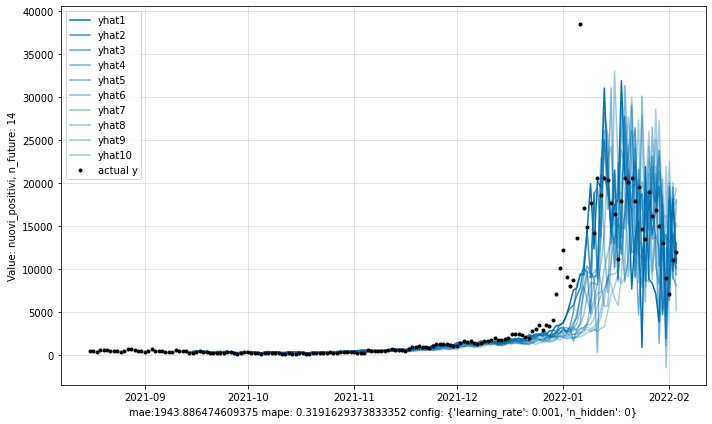

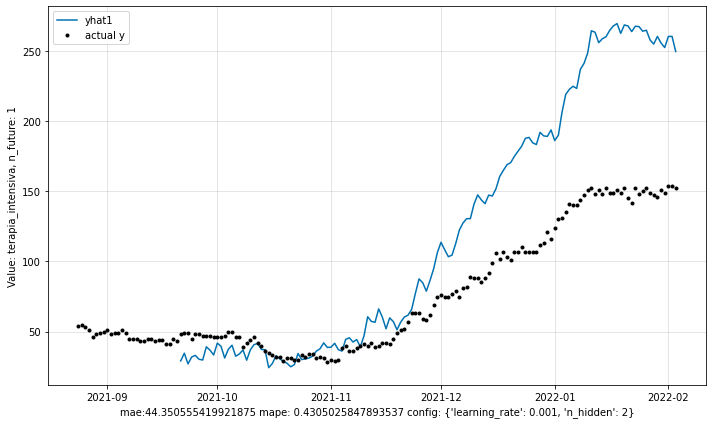

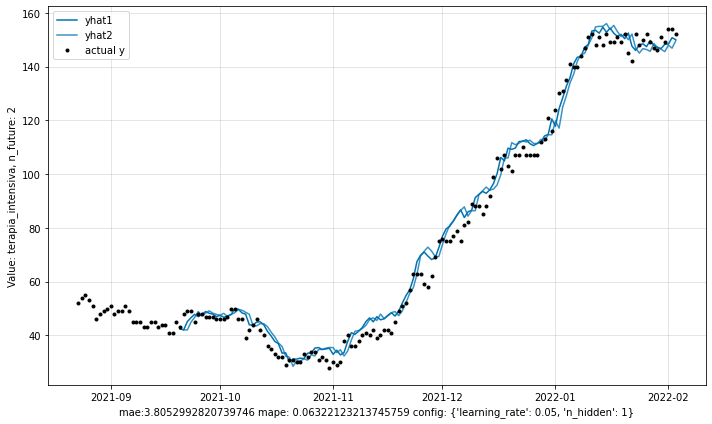

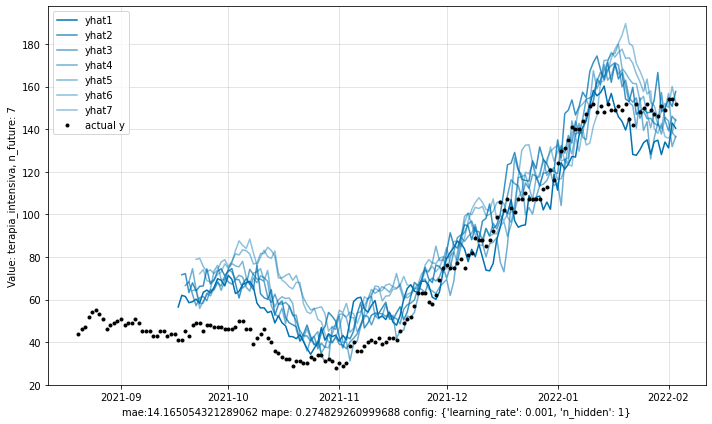

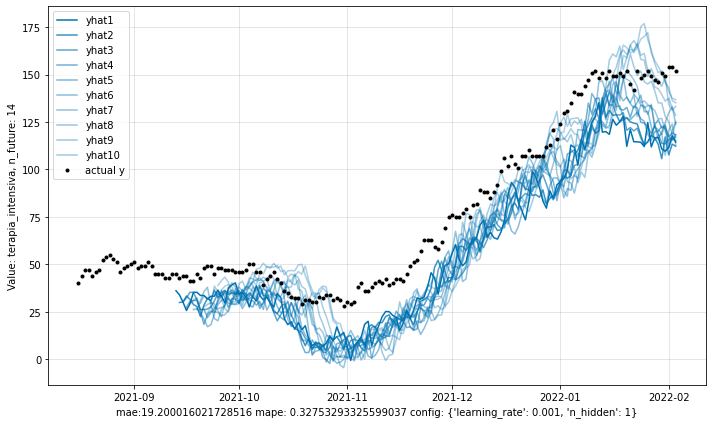

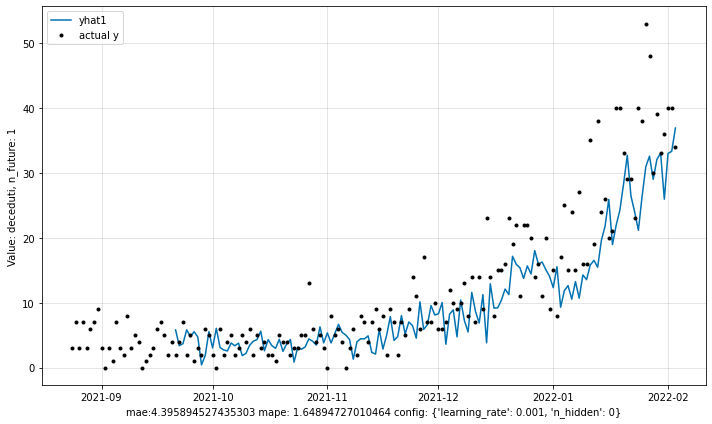

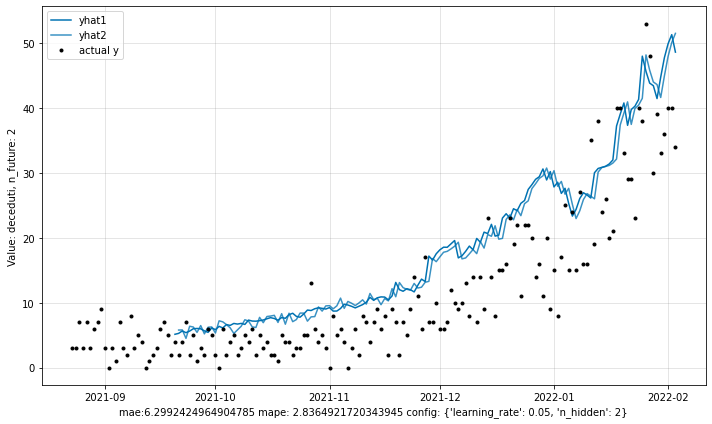

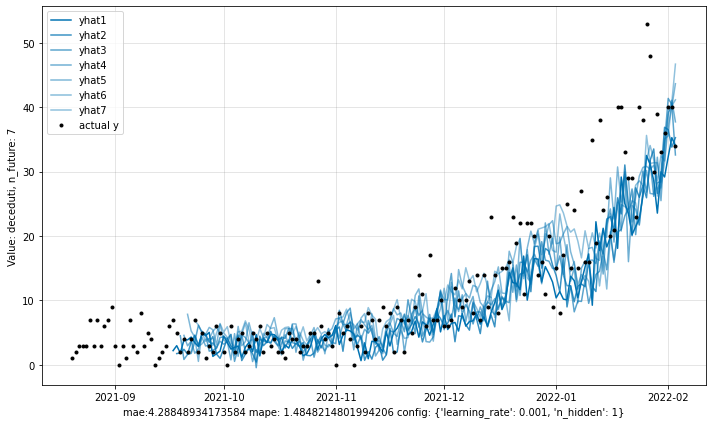

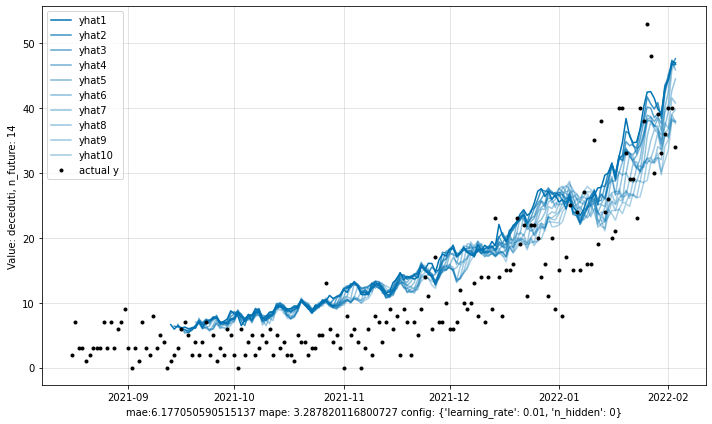

In [29]:
table_result = pd.DataFrame(columns=['mae', 'mape'])

for column_to_predict in columns:
    for n_future in n_futures:
        split = int(split_percent * len(df))
        
        current = df[[column_to_predict]].reset_index().copy()
        current.columns = ['ds', 'y']

        holdout = current[:split]
        results = []

        config_path = region_focus + '_' + 'uni_nerualprophet_config' + '_' + column_to_predict
        config_path = config_path + '_' + str(n_future)

        if use_existing_config:
            if not os.path.isfile(config_path):
                os.system('wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/configs/' + config_path)
            config = load_config(config_path)
            os.system('rm ' + config_path)
        else:
            for config in define_np_configs():
                m = NeuralProphet(
                    n_lags=28,
                    epochs=200,
                    n_forecasts=n_future,
                    weekly_seasonality=False,
                    changepoints_range=1,
                    daily_seasonality=False,
                    yearly_seasonality=False,
                    learning_rate=config['learning_rate'],
                    num_hidden_layers=config['n_hidden'],
                    normalize='minmax'
                )

                df_train, df_test = m.split_df(df=holdout, freq="D", valid_p=1-split_percent)

                metrics_train = m.fit(df=df_train, validation_df=df_test,freq="D", progress_print=False, progress_bar=False)
                metrics_test = m.test(df=df_test)

                mae = metrics_test['MAE'][0]

                results.append((mae, config))
        
            results.sort()
            config = results[0][-1]
            save_config(config_path, config)

        m = NeuralProphet(
            n_lags=28,
            epochs=200,
            n_forecasts=n_future,
            weekly_seasonality=False,
            changepoints_range=1,
            daily_seasonality=False,
            yearly_seasonality=False,
            learning_rate=config['learning_rate'],
            num_hidden_layers=config['n_hidden'],
            normalize='minmax'
        )

        df_train, df_test = m.split_df(df=current, freq="D", valid_p=1-split_percent)

        metrics_train = m.fit(df=df_train, validation_df=df_test,freq="D", progress_print=False, progress_bar=False)
        metrics_test = m.test(df=df_test)

        forecast = m.predict(df=df_test)

        mae = metrics_test['MAE'][0]
        mape = compute_mape(forecast, n_future)

        ylabel = 'Value: ' + column_to_predict + ', n_future: ' + str(n_future)
        xlabel = 'mae:' + str(mae) + ' mape: ' + str(mape) + ' config: ' + str(config)

        m.plot(forecast, ylabel=ylabel, xlabel=xlabel)
        
        values_to_add = {'mae': mae, 'mape':mape}
        row_to_add = pd.Series(values_to_add, name = column_to_predict + ' ' + str(n_future))

        table_result = table_result.append(row_to_add)


In [30]:
print(table_result)

                              mae      mape
nuovi_positivi 1      2417.285156  0.427849
nuovi_positivi 2      1164.995605  0.200073
nuovi_positivi 7      1407.120728  0.262295
nuovi_positivi 14     1943.886475  0.319163
terapia_intensiva 1     44.350555  0.430503
terapia_intensiva 2      3.805299  0.063221
terapia_intensiva 7     14.165054  0.274829
terapia_intensiva 14    19.200016  0.327533
deceduti 1               4.395895  1.648947
deceduti 2               6.299242  2.836492
deceduti 7               4.288489  1.484821
deceduti 14              6.177051  3.287820
